In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.io import loadmat 

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)

In [2]:
import networkx as nx

from scipy.stats import bernoulli
from scipy.special import loggamma

from sklearn.preprocessing import OneHotEncoder

import tqdm

from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

In [3]:
import os
import glob
import pickle

In [4]:
from oct2py import octave

In [5]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore', UserWarning)

In [6]:
# R packages
## label.switching
label_switching = importr("label.switching")
## base
base = importr("base")

dollar = base.__dict__["$"]

In [7]:
pd.options.display.max_rows = 1000

In [8]:
from functools import lru_cache

@lru_cache(maxsize = 10000)
def normterm_discrete(n, k):
    if n == 1:
        return np.log(k)
    if k == 1:
        return 1.0
    elif k == 2:
        return np.sum(sorted([ np.exp(loggamma(n+1) - loggamma(t+1) - loggamma(n-t+1) + 
                               t*(np.log(t) - np.log(n)) + (n-t)*(np.log(n-t) - np.log(n))
                        )
                        for t in range(1, n)]))
    else:
        return normterm_discrete(n, k-1) + n/(k-2) * normterm_discrete(n, k-2)

In [9]:
def check_latent_index_variable(z):
    unique_z = sorted(np.unique(z))
    if len(unique_z) == np.max(z) + 1:
        return z
    new_z = np.zeros(z.shape, dtype=np.int)
    for index, current in enumerate(unique_z):
        new_z[z == current] = index
    return new_z

In [10]:
def calc_dnml(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    codelen_x_z = 0.0
    codelen_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen_x_z += n_all * np.log(n_all)
                codelen_x_z += np.log(normterm_discrete(n_all, 2))
            
            if n_pos >=2:
                codelen_x_z -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen_x_z -= n_neg * np.log(n_neg)
            
        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen_z += n_k * (np.log(N) - np.log(n_k))

    codelen_z += np.log(normterm_discrete(N, K))
    
    codelen = codelen_x_z + codelen_z
    
    return codelen, codelen_x_z, codelen_z

In [11]:
def calc_dnml_by_prob_bernoulli(X, Z, alpha, theta, K=3, L=3):    
    N = X.shape[0]
    
    Z1 = np.argmax(Z, axis=1)
    
    Z1 = check_latent_index_variable(Z1)
    Z2 = Z1
    
    codelen_x_z = 0.0
    codelen_z = 0.0
        
    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg
            
            codelen_x_z += -n_pos * np.ma.log(theta[k, l]) - n_neg * np.ma.log(1.0 - theta[k, l])
            if n_all >=2:
                codelen_x_z += np.log(normterm_discrete(n_all, 2))
    
        n_k = np.sum(Z1 == k)
        codelen_z += -n_k * np.log(alpha[k])

    codelen_z += np.log(normterm_discrete(N, K))

    codelen = codelen_x_z + codelen_z

    return codelen, codelen_x_z, codelen_z

In [12]:
def calc_dnml_by_prob_poisson(X, Z, alpha, theta, K=3, L=3, lambda_max=1000):    
    N = X.shape[0]
    
    Z1 = np.argmax(Z, axis=1)
    
    Z1 = check_latent_index_variable(Z1)
    Z2 = Z1
    
    codelen_x_z = 0.0
    codelen_z = 0.0
        
    for k in range(K):
        for l in range(L):
            X_sum = np.sum(X[Z1 == k, :][:, Z2 == l])
            X_loggamma = np.sum(loggamma(X[Z1 == k, :][:, Z2 == l].ravel() + 1))
            
            codelen_x_z += -X_sum * np.ma.log(theta[k, l]) + theta[k, l] + X_loggamma
            codelen_x_z += 0.5 * np.log(1.0/(2.0*np.pi)) + (1.0 + lambda_max/2.0) * np.log(2.0) + codelen_integer(lambda_max)
            
        n_k = np.sum(Z1 == k)
        codelen_z += -n_k * np.log(alpha[k])

    codelen_z += np.log(normterm_discrete(N, K))

    codelen = codelen_x_z + codelen_z

    return codelen, codelen_x_z, codelen_z

In [13]:
def calc_sc(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    sc_x_z = 0.0
    sc_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                sc_x_z += np.log(normterm_discrete(n_all, 2))

    sc_z += np.log(normterm_discrete(N, K))
    
    return sc_x_z, sc_z

In [14]:
def calc_lsc(X, Z1, Z2, K=3, L=3):    
    codelen = 0.0
    N = X.shape[0]

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen += n_all * np.log(n_all)
            
            if n_pos >=2:
                codelen -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen -= n_neg * np.log(n_neg)

        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen += n_k * (np.log(N) - np.log(n_k))

        codelen += (k + (k+1)*(k+2))/2 * np.log(N/(2.0*np.pi)) -(k+1)/2 * np.log(2.0) + \
           (k+1) * loggamma((k+3)/2) - loggamma((k+1)*(k+3)/2) + (k+1)*(k+2)/2 * np.log(np.pi)

    return codelen

In [15]:
def calc_stats(X, z, 
               scores, scores_f, scores_l, h, delta, K=10):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    T = scores.shape[0] + 2*h
    K = scores.shape[1]
    
    codelens = np.array([ codelen_integer(k) for k in range(1, K+1)])
    
    idxes_all = np.nanargmin(scores + codelens, axis=1)
    
    idxes_all = np.hstack((np.nan * np.ones(h), 
                           idxes_all, 
                           np.nan * np.ones(h)))
    
    models_estimated = np.nan * np.ones(T, dtype=np.float)
    models_former = np.nan * np.ones(T, dtype=np.float)
    models_latter = np.nan * np.ones(T, dtype=np.float)
    stats_complete = np.nan * np.ones(T, dtype=np.float)
    
    n_change = 0  # number of changes so far.
    for t in range(h, T-h):
        alpha= (n_change+1/2) / (t+1+1)
        m_estimated = int(idxes_all[t])

        # estimated blocks
        z_t = np.argmax(z[t][m_estimated], axis=1)

        # stochastic complexity
        sc_x_z, sc_z = calc_sc(X[t, :, :], z_t, z_t, m_estimated+1, m_estimated+1)
        # threshold for model change
        eps_M = (sc_x_z + sc_z + codelen_integer(m_estimated+1) - np.log(delta)) / (2.0*h)

        # Lv.3 change (Model change)
        stats_half_t = np.zeros((K, K), dtype=np.float)
        for k1 in range(K):
            stats_former = scores_f[t-h, k1]
            for k2 in range(K):
                if k1 == k2:
                    p = 1.0 - alpha
                else:
                    p = alpha/(K-1)
                stats_latter = scores_l[t-h, k2]
                stats_half_t[k1, k2] = (stats_former + stats_latter) + codelens[k1] - np.log(p)
        m_former_estimated, m_latter_estimated = np.unravel_index(np.nanargmin(stats_half_t), (K, K))
        models_former[t] = m_former_estimated
        models_latter[t] = m_latter_estimated

        stat = 0.5 / h *(scores[t-h, m_estimated] + codelens[m_estimated] - stats_half_t[m_former_estimated, m_latter_estimated])
        stats_complete[t] = stat

        if (t >= 1) & (stat >= eps_M):
            n_change += 1
        models_estimated[t] = m_estimated   

    return stats_complete, models_estimated, models_former, models_latter

In [16]:
def calc_stats_with_modelidx(scores, scores_f, scores_l, idxes_model, idxes_model_f, idxes_model_l, h):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    stats_complete = np.nan * np.ones(idxes_model.shape[0], dtype=np.float)
    for t in range(h, idxes_model.shape[0]-h):
        stat = 0.5/h * (scores[t, int(idxes_model[t])] - \
                        (scores_f[t, int(idxes_model_f[t])] + \
                        scores_l[t, int(idxes_model_l[t])] ))
        stats_complete[t] = stat

    return stats_complete

In [17]:
def codelen_integer(k):
    codelen = np.log(2.865)
    while k >= 0.0:
        codelen += k
        k = np.log(k)
        
    return codelen

In [18]:
outdir = './output'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [19]:
with open('data_processed/X.pkl', 'rb') as f:
    X_all = pickle.load(f)

X_all = np.array(X_all)

In [20]:
X_all.shape

(120, 47, 47)

In [21]:
with open(os.path.join(outdir, 'pi_list.pkl'), 'rb') as f:
    pi_all = pickle.load(f)
with open(os.path.join(outdir, 'theta_list.pkl'), 'rb') as f:
    theta_all = pickle.load(f)
with open(os.path.join(outdir, 'z_list.pkl'), 'rb') as f:
    Z_all = pickle.load(f)

In [22]:
with open(os.path.join(outdir, 'ym_list.pkl'), 'rb') as f:
    ym_list = pickle.load(f)

In [23]:
# relabeling
K = 10
T = X_all.shape[0]

numpy2ri.activate()
for k in range(1, K):
    # t = 1 - 10
    run = label_switching.ecr_iterative_2(
        z=np.vstack([
              np.argmax(Z_all[t][k], axis=1).reshape(1, -1) for t in range(10)
        ]) + 1,
        K=k+1,
        p=np.stack([Z_all[t][k] for t in range(10)])
    )        
    permutations = np.array(dollar(run, "permutations"))
    for t in range(10):
        Z_all[t][k] = Z_all[t][k][:, permutations[t, :]-1]

    for j in range(9):
        start = 10*j + 9
        end = 10*(j+1) + 11
        
        run = label_switching.ecr_iterative_2(
            z=np.vstack([
                  np.argmax(Z_all[t][k], axis=1).reshape(1, -1) for t in range(start, end)
              ]) + 1,
            K=k+1,
            p=np.stack([Z_all[t][k] for t in range(start, end)])
        )
        permutations = np.array(dollar(run, "permutations"))
        for i, t in enumerate(range(start, end)):
            if t == start:
                for tt in range(start+1):
                    Z_all[tt][k] = Z_all[tt][k][:, permutations[i, :]-1]
            else:
                Z_all[t][k] = Z_all[t][k][:, permutations[i, :]-1]

    start = 110
    end = T
    run = label_switching.ecr_iterative_2(
        z=np.vstack([
              np.argmax(Z_all[t][k], axis=1).reshape(1, -1) for t in range(start, end)
          ]) + 1,
        K=k+1,
        p=np.stack([Z_all[t][k] for t in range(start, end)])
    )
    permutations = np.array(dollar(run, "permutations"))
    for i, t in enumerate(range(start, end)):
        if t == start:
            for tt in range(start+1):
                Z_all[tt][k] = Z_all[tt][k][:, permutations[i, :]-1]
        else:
            Z_all[t][k] = Z_all[t][k][:, permutations[i, :]-1]
    
numpy2ri.deactivate()

In [24]:
T = 120
K = 10
h = 1

dnml_whole_list, nml_x_z_whole_list, nml_z_whole_list = \
    np.nan * np.ones((T, K)), np.nan * np.ones((T, K)), np.nan * np.ones((T, K))
dnml_former_list, nml_x_z_former_list, nml_z_former_list = \
    np.nan * np.ones((T, K)), np.nan * np.ones((T, K)), np.nan * np.ones((T, K))
dnml_latter_list, nml_x_z_latter_list, nml_z_latter_list = \
    np.nan * np.ones((T, K)), np.nan * np.ones((T, K)), np.nan * np.ones((T, K))

for t in tqdm.tqdm(range(h, T-h)):
    for k in range(K):
        t_start = t-h
        t_end = t+h

        # whole
        n_whole = np.sum([[np.sum(np.argmax(Z_all[tt][k], axis=1) == v) for v in range(k+1)] 
                          for tt in range(t_start, t_end)], axis=0)

        theta_hat_whole = np.sum(
                [[[np.sum(X_all[tt][np.argmax(Z_all[tt][k], axis=1) == k1, :][:, np.argmax(Z_all[tt][k], axis=1) == k2])
                   for k2 in range(k+1)] for k1 in range(k+1)] 
                   for tt in range(t_start, t_end)], axis=0) / \
                np.sum(
                    [[[np.sum(np.argmax(Z_all[tt][k], axis=1) == k1) * np.sum(np.argmax(Z_all[tt][k], axis=1) == k2) 
                    for k2 in range(k+1)] for k1 in range(k+1)] 
                    for tt in range(t_start, t_end)], axis=0)

        theta_hat_whole = theta_hat_whole[n_whole !=0, :][:, n_whole !=0]
        pi_hat_whole = n_whole[n_whole !=0] /np.sum(n_whole)

        n_cluster_whole = len(pi_hat_whole)
        res_w = np.array([calc_dnml_by_prob_poisson(
                                            X_all[tt, :, :], 
                                            Z_all[tt][k], 
                                            pi_hat_whole, theta_hat_whole,
                                            n_cluster_whole, n_cluster_whole)
                          for tt in range(t_start, t_end)])

        dnml_whole = np.sum(res_w[:, 0])
        nml_x_z_whole = np.sum(res_w[:, 1])
        nml_z_whole = np.sum(res_w[:, 2])
        
        val = dnml_whole_list[t, n_cluster_whole-1]
        if (np.isnan(val) | ( (np.isfinite(val)) & (dnml_whole < val) )):
            dnml_whole_list[t, n_cluster_whole-1] = dnml_whole
            nml_x_z_whole_list[t, n_cluster_whole-1] = nml_x_z_whole
            nml_z_whole_list[t, n_cluster_whole-1] = nml_z_whole

        # former
        n_former = np.sum([[np.sum(np.argmax(Z_all[tt][k], axis=1) == v) for v in range(k+1)] 
                           for tt in range(t_start, t_start+h)], axis=0)

        theta_hat_former = np.sum(
                [[[np.sum(X_all[tt][np.argmax(Z_all[tt][k], axis=1) == k1, :][:, np.argmax(Z_all[tt][k], axis=1) == k2])
                    for k2 in range(k+1)] for k1 in range(k+1)] 
                 for tt in range(t_start, t_start+h)], axis=0) / \
                np.sum(
                    [[[np.sum(np.argmax(Z_all[tt][k], axis=1) == k1) * np.sum(np.argmax(Z_all[tt][k], axis=1) == k2) 
                    for k2 in range(k+1)] for k1 in range(k+1)] 
                    for tt in range(t_start, t_start+h)], axis=0)

        theta_hat_former = theta_hat_former[n_former !=0, :][:, n_former !=0]
        pi_hat_former = n_former[n_former !=0] /np.sum(n_former)
       
        n_cluster_former = len(pi_hat_former)
        res_f = np.array([calc_dnml_by_prob_poisson(
                                            X_all[tt, :, :], 
                                            Z_all[tt][k], 
                                            pi_hat_former, theta_hat_former,
                                            n_cluster_former, n_cluster_former) 
                          for tt in range(t_start, t_start+h)])

        dnml_former = np.sum(res_f[:, 0])
        nml_x_z_former = np.sum(res_f[:, 1])
        nml_z_former = np.sum(res_f[:, 2])
        
        val = dnml_former_list[t, n_cluster_former-1]
        if (np.isnan(val) | ( (np.isfinite(val)) & (dnml_former < val) )):
            dnml_former_list[t, n_cluster_former-1] = dnml_former
            nml_x_z_former_list[t, n_cluster_former-1] = nml_x_z_former
            nml_z_former_list[t, n_cluster_former-1] = nml_z_former

        # latter
        n_latter = np.sum([[np.sum(np.argmax(Z_all[tt][k], axis=1) == v) for v in range(k+1)]
                           for tt in range(t_start+h, t_end)], axis=0)

        theta_hat_latter = np.sum(
                 [[[np.sum(X_all[tt][np.argmax(Z_all[tt][k], axis=1) == k1, :][:, np.argmax(Z_all[tt][k], axis=1) == k2])
                    for k2 in range(k+1)] for k1 in range(k+1)] for tt in range(t_start+h, t_end)], axis=0) / \
                np.sum(
                 [[[np.sum(np.argmax(Z_all[tt][k], axis=1) == k1) * np.sum(np.argmax(Z_all[tt][k], axis=1) == k2) 
                    for k2 in range(k+1)] for k1 in range(k+1)] for tt in range(t_start+h, t_end)], axis=0)

        theta_hat_latter = theta_hat_latter[n_latter != 0, :][:, n_latter !=0]
        pi_hat_latter = n_latter[n_latter != 0] /np.sum(n_latter)

        n_cluster_latter = len(pi_hat_latter)
        res_l = np.array([calc_dnml_by_prob_poisson(
                                            X_all[tt, :, :], 
                                            Z_all[tt][k], 
                                            pi_hat_latter, theta_hat_latter,
                                            n_cluster_latter, n_cluster_latter) for tt in range(t_start+h, t_end)])

        dnml_latter = np.sum(res_l[:, 0])
        nml_x_z_latter = np.sum(res_l[:, 1])
        nml_z_latter = np.sum(res_l[:, 2])
        
        val = dnml_latter_list[t, n_cluster_latter-1]
        if (np.isnan(val) | ( (np.isfinite(val)) & (dnml_latter < val) )):
            dnml_latter_list[t, n_cluster_latter-1] = dnml_latter
            nml_x_z_latter_list[t, n_cluster_latter-1] = nml_x_z_latter
            nml_z_latter_list[t, n_cluster_latter-1] = nml_z_latter

100%|██████████| 118/118 [00:22<00:00,  6.24it/s]


In [25]:
delta = 0.05
T = X_all.shape[0]

dnml, models_estimated, models_former, models_latter = calc_stats(
    X_all, Z_all, dnml_whole_list[h:(T-h), :], dnml_former_list[h:(T-h), :], dnml_latter_list[h:(T-h), :], h, delta=delta)

nml_x_z = calc_stats_with_modelidx(nml_x_z_whole_list, nml_x_z_former_list, nml_x_z_latter_list, 
                                   models_estimated, models_former, models_latter, h)
 
nml_z = calc_stats_with_modelidx(nml_z_whole_list, nml_z_former_list, nml_z_latter_list, 
                                 models_estimated, models_former, models_latter, h)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [26]:
dnml_df = pd.DataFrame(dnml.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_x_z_df = pd.DataFrame(nml_x_z.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_z_df = pd.DataFrame(nml_z.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()

In [27]:
dnml_df_melt = dnml_df.melt(id_vars='index')
dnml_df_melt['variable'] = dnml_df_melt['variable'].astype(int)

nml_x_z_df_melt = nml_x_z_df.melt(id_vars='index')
nml_x_z_df_melt['variable'] = nml_x_z_df_melt['variable'].astype(int)

nml_z_df_melt = nml_z_df.melt(id_vars='index')
nml_z_df_melt['variable'] = nml_z_df_melt['variable'].astype(int)

In [28]:
dnml_df_melt['criterion'] = 'DNML'
nml_x_z_df_melt['criterion'] = 'NML (X|Z)'
nml_z_df_melt['criterion'] = 'NML (Z)'

In [29]:
idx_201103 = np.where(ym_list == 2011000303)[0]
idx_201108 = np.where(ym_list == 2011000808)[0]

In [30]:
dnml_df_melt['variable'] = dnml_df_melt['variable'].astype(np.int)
nml_z_df_melt['variable'] = nml_z_df_melt['variable'].astype(np.int)
nml_x_z_df_melt['variable'] = nml_x_z_df_melt['variable'].astype(np.int)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


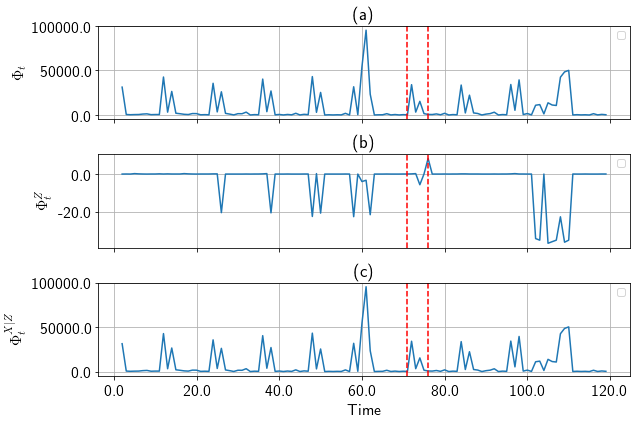

In [31]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(9, 6))

fontsize_title = 18
fontsize = 16

sns.lineplot(x='variable', y='value', data=dnml_df_melt, ax=axes[0])
axes[0].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[0].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[0].grid()
axes[0].set_title('(a)', fontsize=fontsize_title)
axes[0].set_xlabel('Time', fontsize=fontsize)
axes[0].set_ylabel(r'$\Phi_{t}$', fontsize=fontsize)
axes[0].legend(loc='best')

sns.lineplot(x='variable', y='value', data=nml_z_df_melt, ax=axes[1])
axes[1].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[1].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[1].grid()
axes[1].set_title('(b)', fontsize=fontsize_title)
axes[1].set_xlabel('Time', fontsize=fontsize)
axes[1].set_ylabel(r'$\Phi_{t}^{Z}$', fontsize=fontsize)
axes[1].legend(loc='best')

sns.lineplot(x='variable', y='value', data=nml_x_z_df_melt, ax=axes[2])
axes[2].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[2].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[2].grid()
axes[2].set_title('(c)', fontsize=fontsize_title)
axes[2].set_xlabel('Time', fontsize=fontsize)
axes[2].set_ylabel(r'$\Phi_{t}^{X|Z}$', fontsize=fontsize)
axes[2].legend(loc='best')

for ax in axes:
    fontProperties = {'family':'sans-serif', 'weight': 'normal', 'size': 16}
    ax.set_xticklabels(ax.get_xticks(), fontProperties)
    ax.set_yticklabels(ax.get_yticks(), fontProperties)

fig.tight_layout()

plt.show()

# Deltacon

In [32]:
outdir = './output/deltacon'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [33]:
octave.addpath('./deltacon')

'.:/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/oct2py:/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/octave_kernel:/usr/local/Cellar/octave/5.1.0_8/share/octave/site/m:/usr/local/Cellar/octave/5.1.0_8/share/octave/site/m/startup:/usr/local/Cellar/octave/5.1.0_8/lib/octave/5.1.0/oct/x86_64-apple-darwin18.7.0:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/audio:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/deprecated:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/elfun:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/general:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/geometry:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/gui:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/help:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/image:/usr/local/Cellar/octave/5.1.0_8/share/octave/5.1.0/m/io:/usr/local/Cellar/octa

In [34]:
for t in tqdm.tqdm(range(X_all.shape[0])):
    idxes_i, idxes_j = np.where(X_all[t, :, :] == 1)
    res = np.hstack((idxes_i.reshape(-1, 1) + 1, 
                     idxes_j.reshape(-1, 1) + 1, 
                     np.ones((len(idxes_i), 1), dtype=np.int)
                    )
                   ).astype(np.int)
    fname = os.path.join(outdir, 'edgelist_%03d.txt' % (t))
    np.savetxt(fname, res, fmt='%i')

100%|██████████| 120/120 [00:00<00:00, 1446.39it/s]


In [35]:
X_all.shape

(120, 47, 47)

In [36]:
n_time = X_all.shape[0]

scores_deltacon = [np.nan]
idxes_list = [os.path.join(outdir, 'edgelist_%03d.txt' % (t)) for t in range(n_time)]

for t in range(1, n_time):
    edgelist_prev = idxes_list[t-1]
    edgelist_cur = idxes_list[t]
    score_t = octave.feval('DeltaCon', 'edge', 'naive', edgelist_prev, edgelist_cur, 0.1)
    scores_deltacon.append(score_t)

scores_deltacon = np.array(scores_deltacon)
    
df_scores_deltacon = pd.DataFrame({'time': np.arange(1, n_time+1),
                          'score': scores_deltacon,
                          'dissim': (1.0 - scores_deltacon)}, 
                          columns=['time', 'score', 'dissim'])

In [37]:
nml_df_melt = dnml_df_melt.copy()
nml_df_melt['criterion'] = 'NML'

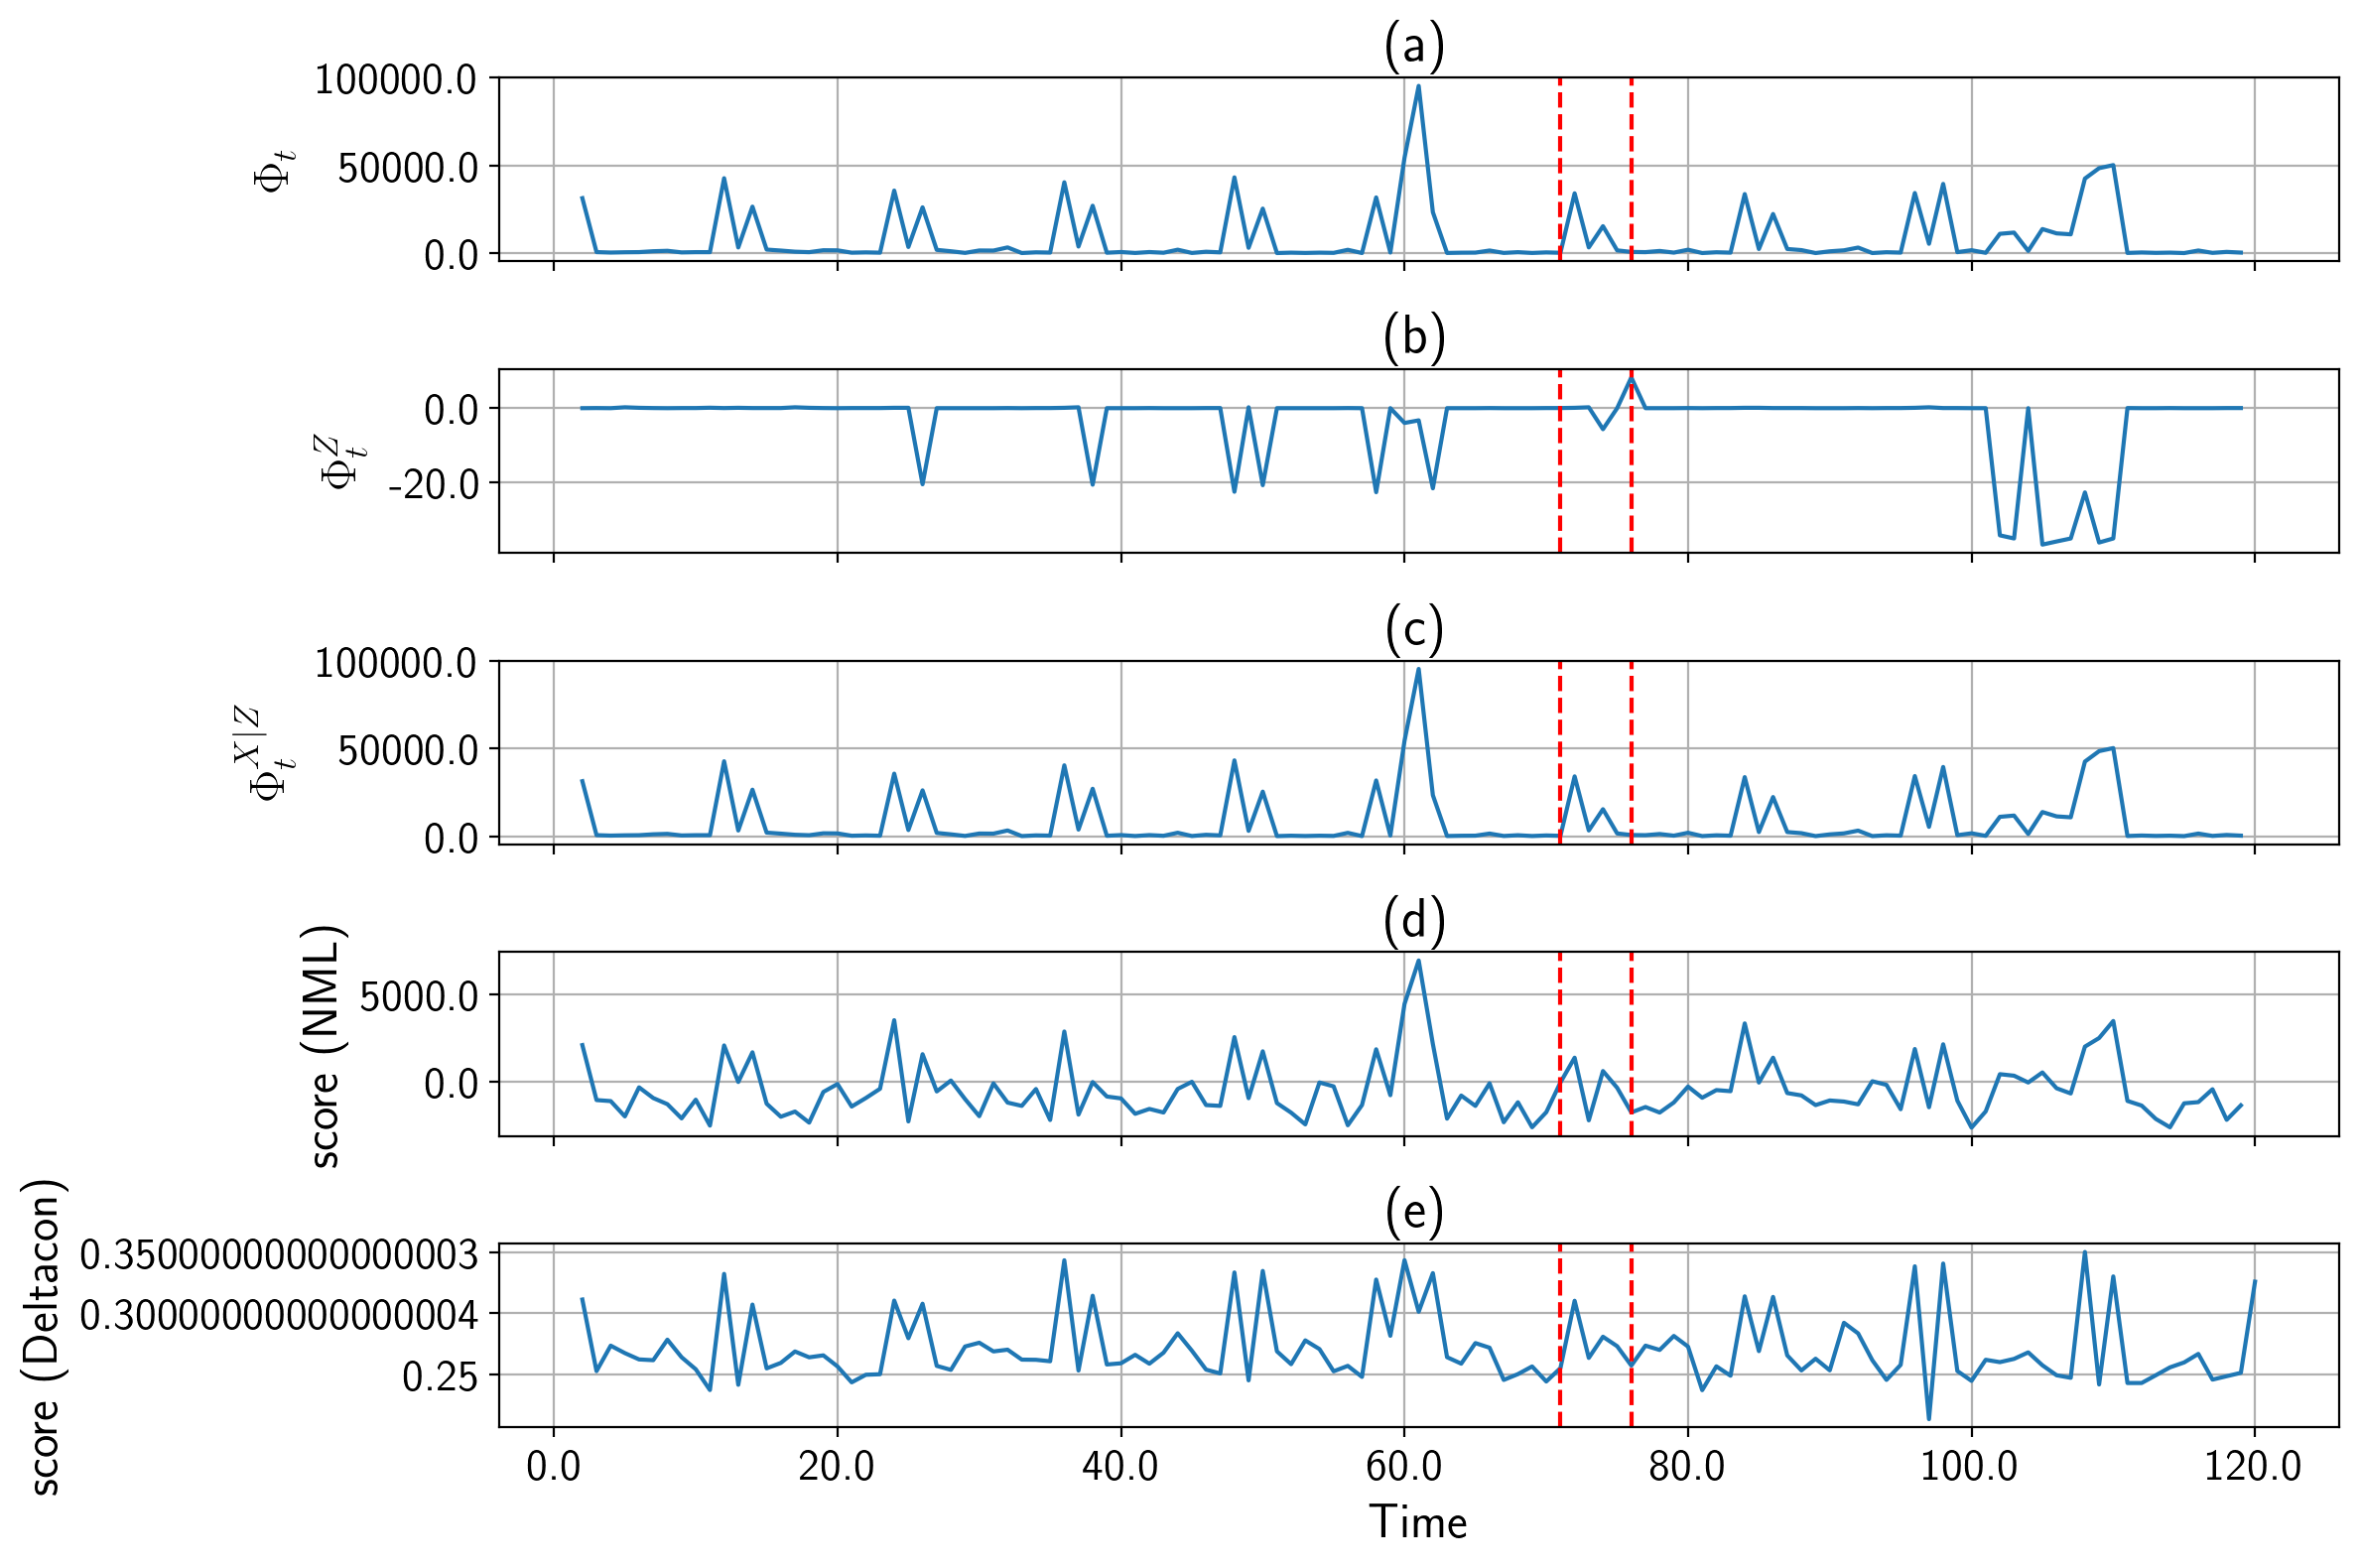

In [38]:
fontsize_title = 20
fontsize = 18

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(12, 8), dpi=200)

sns.lineplot(x='variable', y='value', data=dnml_df_melt, ax=axes[0])
axes[0].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[0].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[0].grid()
axes[0].set_title('(a)', fontsize=fontsize_title)
axes[0].set_xlabel('Time', fontsize=fontsize)
axes[0].set_ylabel(r'$\Phi_{t}$', fontsize=fontsize)
#axes[0].legend(loc='best')

sns.lineplot(x='variable', y='value', data=nml_z_df_melt, ax=axes[1])
axes[1].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[1].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[1].grid()
axes[1].set_title('(b)', fontsize=fontsize_title)
axes[1].set_xlabel('Time', fontsize=fontsize)
axes[1].set_ylabel(r'$\Phi_{t}^{Z}$', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=nml_x_z_df_melt, ax=axes[2])
axes[2].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[2].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[2].grid()
axes[2].set_title('(c)', fontsize=fontsize_title)
axes[2].set_xlabel('Time', fontsize=fontsize)
axes[2].set_ylabel(r'$\Phi_{t}^{X|Z}$', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=nml_df_melt, ax=axes[3])
axes[3].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[3].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[3].grid()
axes[3].set_title('(d)', fontsize=fontsize_title)
axes[3].set_xlabel('Time', fontsize=fontsize)
axes[3].set_ylabel('score (NML)', fontsize=fontsize)

ax = sns.lineplot(x='time', y='dissim', data=df_scores_deltacon, ax=axes[4])
axes[4].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[4].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[4].grid()
axes[4].set_title('(e)', fontsize=fontsize_title)
axes[4].set_xlabel('Time', fontsize=fontsize)
axes[4].set_ylabel('score (Deltacon)', fontsize=fontsize)
#ax.set_yticklabels([0.25, 0.3, 0.35])

for ax in axes:
    fontProperties = {'family':'sans-serif', 'weight': 'normal', 'size': 16}
    ax.set_xticklabels(ax.get_xticks(), fontProperties)
    ax.set_yticklabels(ax.get_yticks(), fontProperties)

fig.tight_layout()

plt.show()